# BPNet Hits Summarize

Call significant hits from BPNet counts deltas and then get peak set x motif map.

In [112]:
library(ggplot2)
library(GenomicRanges)
library(rtracklayer)
library(reshape2)
library(scales)
library(matrixStats)

## Load Data

### PWM Hits

In [3]:
# all putative motif matches (from HOMER/FIMO scan)
pwm_hits = import("./pwm_hits/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40/homer.all.sorted.bed")
length(pwm_hits)
head(pwm_hits)

[1] 7848623

GRanges object with 6 ranges and 2 metadata columns:
      seqnames              ranges strand |        name     score
         <Rle>           <IRanges>  <Rle> | <character> <numeric>
  [1]    chr10 100000298-100000307      - |  Atf4(bZIP)  8.032424
  [2]    chr10 100000356-100000365      - |   Sox4(HMG)  7.254576
  [3]    chr10 100000358-100000365      - |   Sox3(HMG)   6.83442
  [4]    chr10 100000426-100000435      + | Olig2(bHLH)    6.4031
  [5]    chr10 100000432-100000446      + |   Rfx6(HTH)  6.827114
  [6]    chr10 100000481-100000495      - |    Zic3(Zf)  7.970766
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [86]:
# reads homer Motif.Names (first column) and breaks them into 
# TF name and family name (if available)
# if family name not available, uses name of TF itself
get_tf_fam <- function(homer_motif_names) {
    tfs = c()
    fams = c()
    for (x in as.character(homer_motif_names)) {
        tf_fam = strsplit(x, "/")[[1]][1]
        tf_fam = strsplit(tf_fam, "\\(")[[1]]

        if (length(tf_fam)==2) {
            tf = tf_fam[1]
            fam = sub(")", "", tf_fam[2])
        }

        else {
            tf = tf_fam[1]
            fam = tf
        }
        
        tfs = c(tfs, tf)
        fams = c(fams, fam)
    }
    
    list(tfs, fams)
}

### Peak Sets

In [4]:
BASE_PATH = "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40/"
list.files(BASE_PATH)

[1] "all_peaks.bed" "idx1.bed"      "idx10.bed"     "idx11.bed"    
 [5] "idx12.bed"     "idx13.bed"     "idx14.bed"     "idx15.bed"    
 [9] "idx16.bed"     "idx17.bed"     "idx18.bed"     "idx19.bed"    
[13] "idx2.bed"      "idx20.bed"     "idx21.bed"     "idx22.bed"    
[17] "idx23.bed"     "idx24.bed"     "idx25.bed"     "idx26.bed"    
[21] "idx27.bed"     "idx28.bed"     "idx29.bed"     "idx3.bed"     
[25] "idx30.bed"     "idx31.bed"     "idx32.bed"     "idx33.bed"    
[29] "idx34.bed"     "idx35.bed"     "idx36.bed"     "idx37.bed"    
[33] "idx38.bed"     "idx39.bed"     "idx4.bed"      "idx40.bed"    
[37] "idx5.bed"      "idx6.bed"      "idx7.bed"      "idx8.bed"     
[41] "idx9.bed"      "README.md"     "width_200bp"

In [5]:
PEAK_SET_BEDS = list.files(BASE_PATH, 
                           full.names=T,
                          pattern="*idx[0-9]*")
PEAK_SET_NAMES = sub(".bed", "", list.files(BASE_PATH, 
                          pattern="*idx[0-9]*"))
length(PEAK_SET_BEDS)
length(PEAK_SET_NAMES)

[1] 40

[1] 40

In [6]:
# alphanumeric sort 
PEAK_SET_BEDS = PEAK_SET_BEDS[order(nchar(PEAK_SET_BEDS), PEAK_SET_BEDS)]
PEAK_SET_NAMES = PEAK_SET_NAMES[order(nchar(PEAK_SET_NAMES), PEAK_SET_NAMES)]

In [7]:
PEAK_SET_BEDS
PEAK_SET_NAMES

[1] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx1.bed" 
 [2] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx2.bed" 
 [3] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx3.bed" 
 [4] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx4.bed" 
 [5] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx5.bed" 
 [6] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx6.bed" 
 [7] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx7.bed" 
 [8] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx8.bed" 
 [9] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx9.bed" 
[10] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx10.bed"
[11] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx11.bed"
[12] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx12.bed"
[13] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx13.bed"
[14] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx14.bed"
[15] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx15.bed"
[16] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx16.bed"
[17] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx17.bed"
[18] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx18.bed"
[19] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx19.bed"
[20] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx20.bed"
[21] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx21.bed"
[22] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx22.bed"
[23] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx23.bed"
[24] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx24.bed"
[25] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx25.bed"
[26] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx26.bed"
[27] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx27.bed"
[28] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx28.bed"
[29] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx29.bed"
[30] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx30.bed"
[31] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx31.bed"
[32] "../../analysis/20200307_fine_clustering/beds/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40//idx32.bed"
[33] "../../analysis/20200307_fin

[1] "idx1"  "idx2"  "idx3"  "idx4"  "idx5"  "idx6"  "idx7"  "idx8"  "idx9" 
[10] "idx10" "idx11" "idx12" "idx13" "idx14" "idx15" "idx16" "idx17" "idx18"
[19] "idx19" "idx20" "idx21" "idx22" "idx23" "idx24" "idx25" "idx26" "idx27"
[28] "idx28" "idx29" "idx30" "idx31" "idx32" "idx33" "idx34" "idx35" "idx36"
[37] "idx37" "idx38" "idx39" "idx40"

## Call BPNet Hits

Call significant motif hits from BPNet deltas for PWM hits (HOMER/FIMO) and null sequences (PWM hits shifted +/- 50bp).

In [8]:
NUM_CELL_STATES = 18

In [934]:
BPNET_ISM_DIR = "./bpnet_scores/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40/block_ism"

get_sig_peaks <- function(i, thresh=0.01) {
    motif_preds_file = sprintf("%s/cluster_idx%d.pred.tsv", BPNET_ISM_DIR, i)
    null_preds_file = sprintf("%s/cluster_idx%d.pred.null.tsv", BPNET_ISM_DIR, i)
    motif_preds = read.table(motif_preds_file, header=T)
    null_preds = read.table(null_preds_file, header=T)
    
    # right now simple cutoff based on ref-mut pred of null
    cutoff = quantile(null_preds$ref_task_0 - null_preds$mut_task_0, 1-thresh)
    
    motif_preds[motif_preds$ref_task_0 - motif_preds$mut_task_0 > cutoff, c("chr", "start", "end")]
}

In [935]:
sig_hits = mclapply(seq(NUM_CELL_STATES), get_sig_peaks, mc.cores = 20)

In [936]:
# consolidate across cell states
consolidated_sig_hits = unique(do.call(rbind, sig_hits))
consolidated_sig_hits = makeGRangesFromDataFrame(consolidated_sig_hits)

In [937]:
consolidated_sig_hits

GRanges object with 1207402 ranges and 0 metadata columns:
           seqnames          ranges strand
              <Rle>       <IRanges>  <Rle>
        66     chr1   818782-818794      *
       120     chr1   858878-858894      *
       133     chr1   869917-869937      *
       134     chr1   869919-869939      *
       174     chr1   910154-910164      *
       ...      ...             ...    ...
   2016286     chrY 5215285-5215297      *
   2016287     chrY 5215286-5215298      *
  20162881     chrY 5708947-5708962      *
  20162992     chrY 5710139-5710159      *
  20163001     chrY 5710163-5710173      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [938]:
# overlap with motif calls (sig hits are peaks that subsume all motif calls)
sig_pwm_hits = pwm_hits[unique(queryHits(findOverlaps(pwm_hits, consolidated_sig_hits, type='within')))]
length(sig_pwm_hits)

[1] 2639059

In [939]:
head(sig_pwm_hits)

GRanges object with 6 ranges and 2 metadata columns:
      seqnames              ranges strand |               name     score
         <Rle>           <IRanges>  <Rle> |        <character> <numeric>
  [1]    chr10 100000543-100000554      - | Oct6(POU,Homeobox)  8.511639
  [2]    chr10 100006087-100006101      - |          Rfx6(HTH)  4.739767
  [3]    chr10 100006090-100006101      - |         Atf3(bZIP)  6.918307
  [4]    chr10 100006091-100006100      - |         AP-1(bZIP)  6.569239
  [5]    chr10 100006091-100006100      + |         BATF(bZIP)  7.194372
  [6]    chr10 100006091-100006100      + |         JunB(bZIP)   7.16048
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [940]:
# write to file
df = data.frame(seq=seqnames(sig_pwm_hits),
               starts = format(start(sig_pwm_hits)-1, scientific = F),
               ends=format(end(sig_pwm_hits), scientific=F),
               names=sig_pwm_hits$name,
               score=score(sig_pwm_hits),
               strands=strand(sig_pwm_hits))

# write.table(df, file="./bpnet_scores/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40/hits.bpnet.01.bed",
#            sep='\t', row.names=F, col.names=F, quote=F)`

### Examine Pred vs Null for a cell state

In [867]:
motif_preds_file = sprintf("%s/cluster_idx%d.pred.tsv", BPNET_ISM_DIR, 17)
null_preds_file = sprintf("%s/cluster_idx%d.pred.null.tsv", BPNET_ISM_DIR, 17)
motif_preds = read.table(motif_preds_file, header=T)
null_preds = read.table(null_preds_file, header=T)

In [885]:
# convert to base 2
motif_preds$ref_task_0 = (1/log(2))*motif_preds$ref_task_0
motif_preds$mut_task_0 = (1/log(2))*motif_preds$mut_task_0
null_preds$ref_task_0 = (1/log(2))*null_preds$ref_task_0
null_preds$mut_task_0 = (1/log(2))*null_preds$mut_task_0

In [933]:
quantile(null_preds$ref_task_0 - null_preds$mut_task_0, c(0.9 ,0.99, 0.999, 0.9999, 1))

90%        99%      99.9%     99.99%       100% 
0.08102378 0.26424936 0.49811040 0.79000595 2.02666282

Warning message:
“Removed 136 rows containing missing values (geom_point).”
Warning message:
“Removed 85 rows containing missing values (geom_point).”


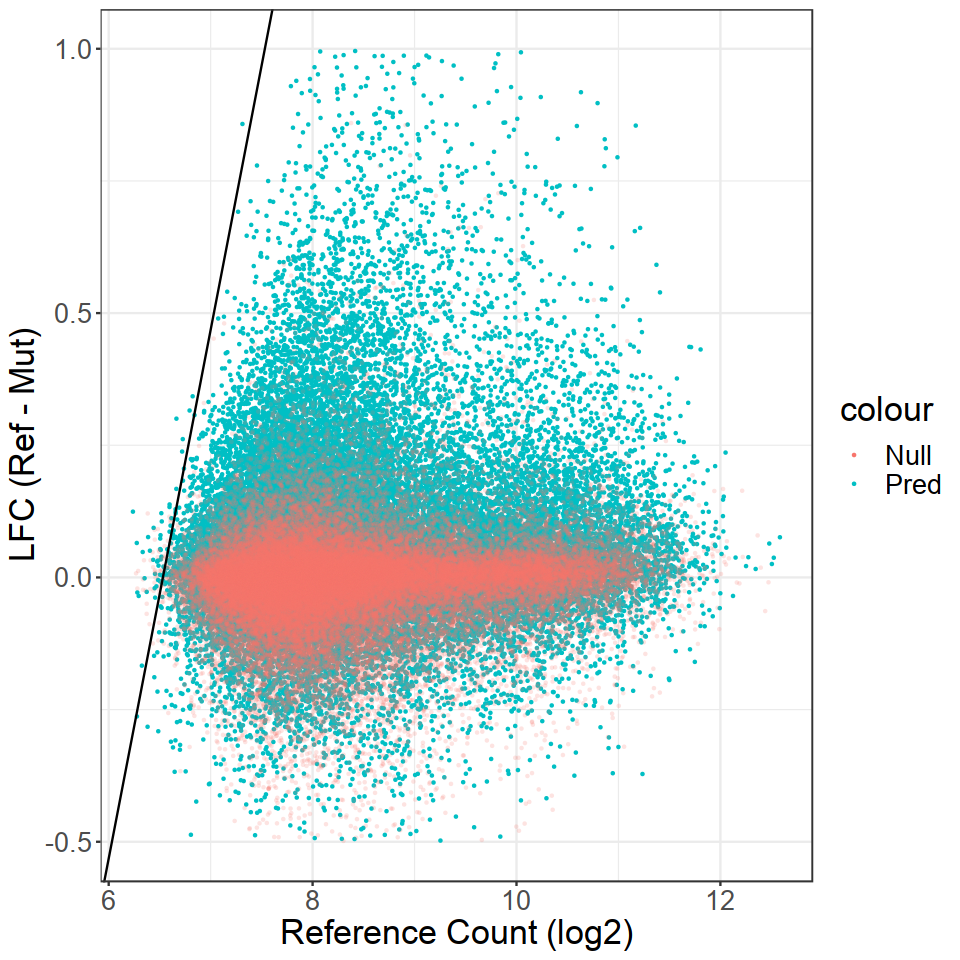

In [1026]:
options(repr.plot.width = 8, repr.plot.height = 8)

NSAMP = 50000
ggplot(motif_preds[sample(nrow(motif_preds), NSAMP), ]) + 
geom_point(aes(x=ref_task_0, y=ref_task_0-mut_task_0, colour='Pred'), stroke=0,  alpha=1, size=1) +
geom_point(data=null_preds[sample(nrow(null_preds), NSAMP), ], aes(x=ref_task_0, y=ref_task_0-mut_task_0, colour='Null'), 
                                                                   stroke=0, alpha=0.2, size=1) +
ylim(c(-0.5,1)) +
xlab("Reference Count (log2)") +
ylab("LFC (Ref - Mut)") +
geom_abline(slope=1, intercept = -quantile(motif_preds$ref_task_0, 0.001)) +
theme_bw() + 
theme(text = element_text(size=20))

### Peak x Motif Matrix for ChromVAR or similar

In [971]:
library(Matrix)


Attaching package: ‘Matrix’


The following object is masked from ‘package:S4Vectors’:

    expand




In [960]:
all_peaks= import("../20200206_pmat_snapATAC/sessions/20200520_n68916/peaks.overlap.smallpeaks.bed")

In [961]:
all_peaks

GRanges object with 803958 ranges and 0 metadata columns:
           seqnames              ranges strand
              <Rle>           <IRanges>  <Rle>
       [1]     chr1   97145605-97145864      *
       [2]     chr1     7538149-7538363      *
       [3]     chr1   93196679-93196894      *
       [4]     chr1 187577714-187577913      *
       [5]     chr1   53278066-53278265      *
       ...      ...                 ...    ...
  [803954]     chrY     7500308-7500509      *
  [803955]     chrY     7447985-7448191      *
  [803956]     chrY   14733641-14733856      *
  [803957]     chrY   12662453-12662752      *
  [803958]     chrY   12681581-12681865      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

In [963]:
overlaps = findOverlaps(sig_pwm_hits, all_peaks, type='within')
overlaps

Hits object with 2639059 hits and 0 metadata columns:
            queryHits subjectHits
            <integer>   <integer>
        [1]         1      350235
        [2]         2      332569
        [3]         3      332569
        [4]         4      332569
        [5]         5      332569
        ...       ...         ...
  [2639055]   2639055      803883
  [2639056]   2639056      803885
  [2639057]   2639057      803885
  [2639058]   2639058      803438
  [2639059]   2639059      803438
  -------
  queryLength: 2639059 / subjectLength: 803958

In [967]:
query_motif = sig_pwm_hits[queryHits(overlaps)]$name
query_motif = factor(query_motif)

In [977]:
all_peaks_x_motif = sparseMatrix(i=subjectHits(overlaps),
                                 j=as.numeric(query_motif),
                                 dims=c(length(all_peaks), length(levels(query_motif))),
                                dimnames=list(as.character(all_peaks), levels(query_motif)))

In [984]:
writeMM(all_peaks_x_motif, 
        file="./bpnet_scores/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40/peaks.overlap.smallpeaks.hits.bpnet.01.mm")

write.table(levels(query_motif), 
            file="./bpnet_scores/20200705_gridmap_peakwidthnorm_logplusznorm_4way_ordered_n40/peaks.overlap.smallpeaks.hits.bpnet.01.motif.names.txt",
           quote=F, row.names=F, col.names=F)

### Concordance between PWM scores and BPNet hits

In [810]:
library(PRROC)

In [811]:
auprcs = list()
aucs = list()
frac_pos = list()

for (motif in unique(pwm_hits$name)) {
    motif_bpnet_hits = sig_pwm_hits[sig_pwm_hits$name==motif]
    motif_pwm_hits = pwm_hits[pwm_hits$name==motif]
    
    frac_pos[[motif]] = length(motif_bpnet_hits)/length(motif_pwm_hits)
    
    labels = as.character(motif_pwm_hits) %in% as.character(motif_bpnet_hits)    
    
    aucs[[motif]] = roc.curve(scores.class0 = motif_pwm_hits$score[labels==T], 
                       scores.class1 = motif_pwm_hits$score[labels==F], curve=T)
    
    auprcs[[motif]] = pr.curve(scores.class0 = motif_pwm_hits$score[labels==T], 
                scores.class1 = motif_pwm_hits$score[labels==F], curve=T)
}

In [812]:
motif_auc_df = data.frame(motif=names(lapply(aucs, "[[", "auc")),
                          auc=as.vector(unlist(lapply(aucs, "[[", "auc"))),
                          auprc=as.vector(unlist(lapply(auprcs, "[[", "auc.davis.goadrich"))))
motif_auc_df = motif_auc_df[order(motif_auc_df$auc), ]
motif_auc_df$motif = factor(motif_auc_df$motif,
                           levels=motif_auc_df$motif)
motif_auc_df$frp = unlist(frac_pos[as.character(motif_auc_df$motif)])
head(motif_auc_df)

,motif,auc,auprc,frp
,<fct>,<dbl>,<dbl>,<dbl>
108,"FOXA1:AR(Forkhead,NR)",0.4605390,0.1169321,0.1304348
2,Sox4(HMG),0.4997135,0.1556967,0.1508328
33,Ap4(bHLH),0.5023841,0.2440872,0.2167839
60,Ascl2(bHLH),0.5115113,0.1637309,0.1576757
42,EBF1(EBF),0.5136086,0.1103938,0.1055018
34,Tcf21(bHLH),0.5149304,0.2824567,0.2578752


In [813]:
motif_auc_df[grep("gamma", motif_auc_df$motif), ]

,motif,auc,auprc,frp
,<fct>,<dbl>,<dbl>,<dbl>
43,AP-2gamma(AP2),0.6043934,0.232007,0.1571842


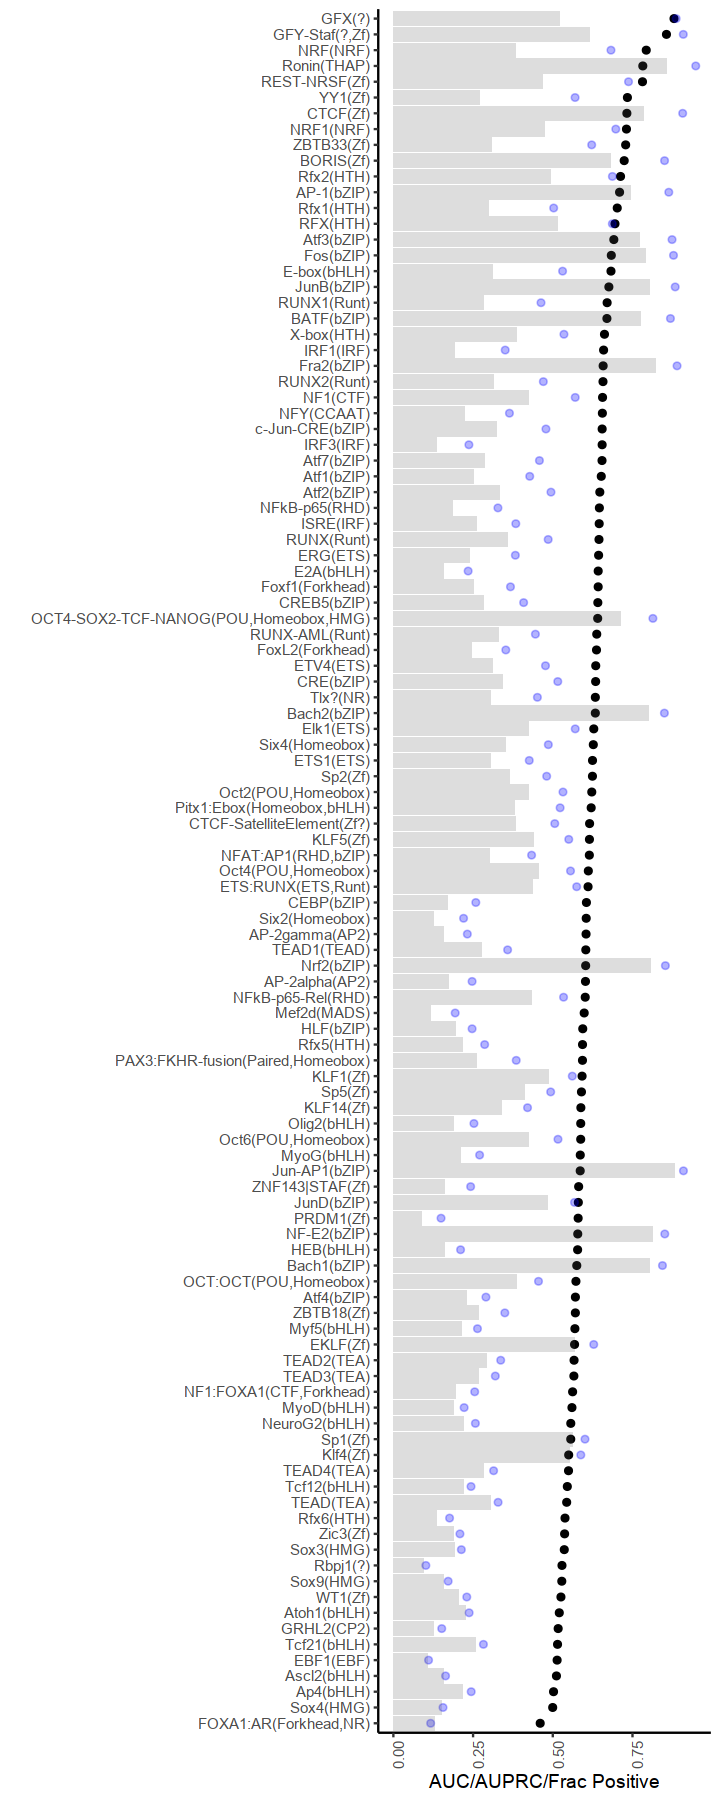

In [814]:
options(repr.plot.width = 6, repr.plot.height = 15)

ggplot(motif_auc_df) +
geom_point(aes(x=motif, y=auc)) + 
geom_point(aes(x=motif, y=auprc), alpha=0.3, colour='blue') + 
geom_bar(aes(x=motif, y=frp), alpha=0.2, stat="identity") +
ylab("AUC/AUPRC/Frac Positive") +
xlab("") +
coord_flip() +
theme_classic() +
theme(axis.text.x = element_text(angle = 90, hjust=0.95)) 

In [815]:
MOTIF = "nfy"
names(aucs)[grep(MOTIF, names(aucs), ignore.case=T)]

MOTIF = names(aucs)[grep(MOTIF, names(aucs), ignore.case=T)][1]
MOTIF

[1] "NFY(CCAAT)"

[1] "NFY(CCAAT)"

[1] 22.20145

[1] 7

[1] 67

[1] 554

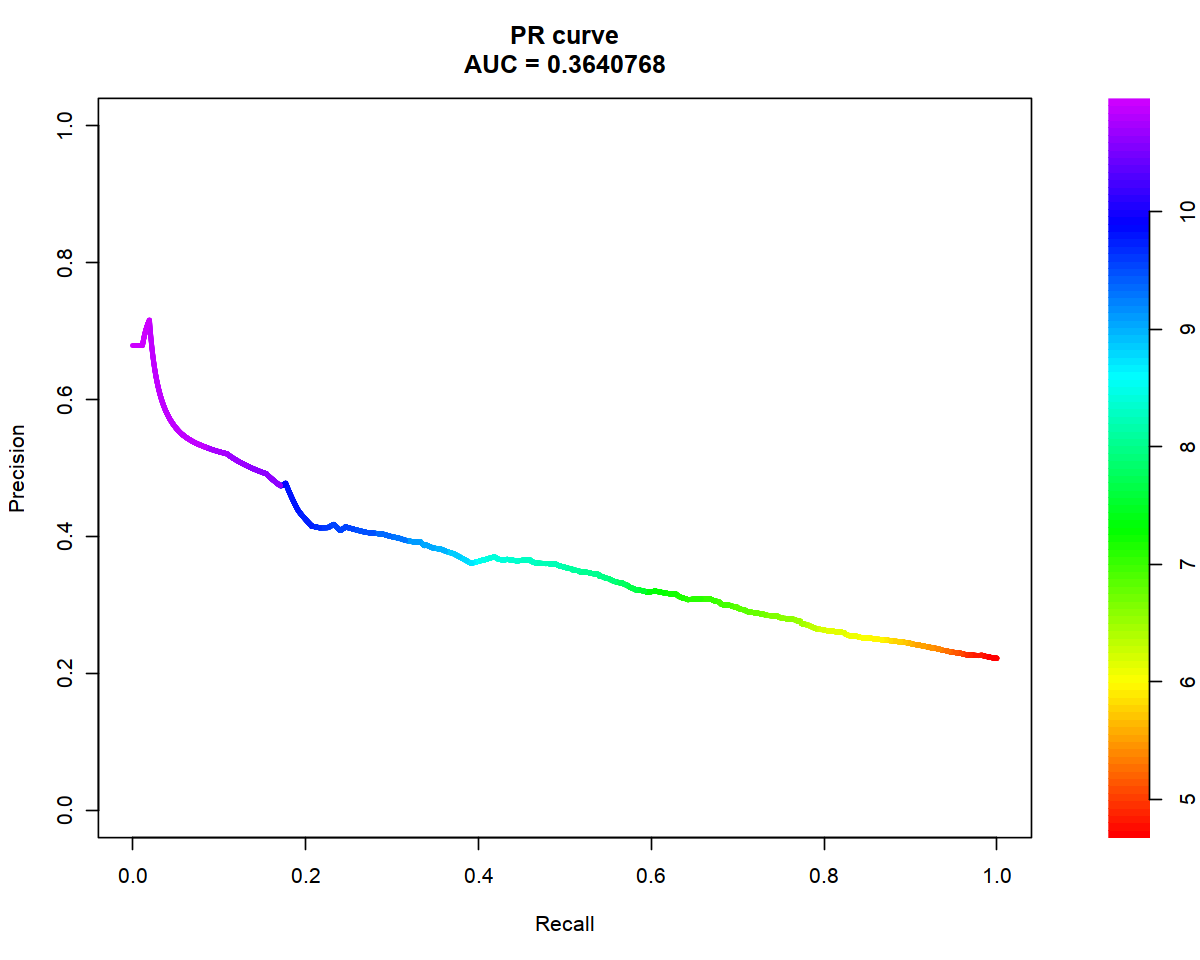

In [816]:
motif_bpnet_hits = as.character(sig_pwm_hits[sig_pwm_hits$name==MOTIF])
motif_pwm_hits = pwm_hits[pwm_hits$name==MOTIF]
motif_pwm_hits = as.character(motif_pwm_hits[rev(order(motif_pwm_hits$score))])

100*frac_pos[[MOTIF]]

# hits at top 10, 100, 1000
sum(motif_pwm_hits[1:10] %in% motif_bpnet_hits)
sum(motif_pwm_hits[1:100] %in% motif_bpnet_hits)
sum(motif_pwm_hits[1:1000] %in% motif_bpnet_hits)

options(repr.plot.width = 10, repr.plot.height = 8)

plot(auprcs[[MOTIF]])

## Peak Set x Motif Breakdown

In [941]:
peak_x_motif_counts = matrix(0, nrow=length(PEAK_SET_BEDS), 
                                 ncol=length(unique(sig_pwm_hits$name)))
rownames(peak_x_motif_counts) = PEAK_SET_NAMES
colnames(peak_x_motif_counts) = unique(sig_pwm_hits$name)

In [942]:
NUM_PEAKS = list()

In [943]:
for (i in seq(length(PEAK_SET_BEDS))) {
    cur_peak_set = import(PEAK_SET_BEDS[[i]])
    NUM_PEAKS[[PEAK_SET_NAMES[[i]]]] = length(cur_peak_set)
    
    # allows counting multiple hits per peak
    cur_motif_counts = table(sig_pwm_hits[queryHits(findOverlaps(sig_pwm_hits, cur_peak_set, type='within'))]$name)
    
    peak_x_motif_counts[PEAK_SET_NAMES[[i]], names(cur_motif_counts)] = cur_motif_counts
}

In [944]:
head(peak_x_motif_counts)

,"Oct6(POU,Homeobox)",Rfx6(HTH),Atf3(bZIP),AP-1(bZIP),BATF(bZIP),JunB(bZIP),Fos(bZIP),Jun-AP1(bZIP),Fra2(bZIP),Bach2(bZIP),⋯,"NFAT:AP1(RHD,bZIP)",NFkB-p65-Rel(RHD),Atf7(bZIP),CRE(bZIP),Nrf2(bZIP),JunD(bZIP),"FOXA1:AR(Forkhead,NR)",YY1(Zf),CTCF-SatelliteElement(Zf?),"NF1:FOXA1(CTF,Forkhead)"
idx1,352,123,3771,3763,3719,3404,3643,1875,3128,837,⋯,141,20,160,28,207,52,14,1,2,19
idx2,120,257,3895,3931,3883,3469,3678,1749,3140,927,⋯,129,62,682,107,277,227,46,2,1,63
idx3,192,179,10276,10253,10171,9266,9868,4677,8318,2223,⋯,369,39,423,102,528,142,17,2,2,20
idx4,392,781,13946,14008,13596,12354,13224,6659,11288,3654,⋯,626,217,1331,323,905,368,52,8,5,124
idx5,343,489,13111,12933,12811,11573,12396,5858,10481,3066,⋯,547,154,1001,209,768,304,55,6,4,87
idx6,315,589,4817,4845,4666,4295,4580,2588,4017,1530,⋯,248,194,800,211,417,256,24,8,7,51


In [1002]:
# filter
MIN_TOTAL_HITS = 5000
peak_x_motif_norm = peak_x_motif_counts[, colSums(peak_x_motif_counts)>MIN_TOTAL_HITS]

# row norm
peak_x_motif_norm = peak_x_motif_norm/rowSums(peak_x_motif_norm)

# col norm by total number of peaks in peakset
# may show higher counts for peak sets part of multiple cell states 
# which would as a result have more called motifs
# peak_x_motif_norm = t(t(peak_x_motif_norm)/unlist(NUM_PEAKS[rownames(peak_x_motif_counts)]))

# column norm to 0-1
peak_x_motif_norm = t(t(peak_x_motif_norm) - colMins(peak_x_motif_norm))
peak_x_motif_norm = t(t(peak_x_motif_norm)/colMaxs(peak_x_motif_norm))
head(peak_x_motif_norm)

,"Oct6(POU,Homeobox)",Rfx6(HTH),Atf3(bZIP),AP-1(bZIP),BATF(bZIP),JunB(bZIP),Fos(bZIP),Jun-AP1(bZIP),Fra2(bZIP),Bach2(bZIP),⋯,Sox9(HMG),CREB5(bZIP),Bach1(bZIP),"Oct2(POU,Homeobox)",Atf2(bZIP),c-Jun-CRE(bZIP),"NFAT:AP1(RHD,bZIP)",Atf7(bZIP),CRE(bZIP),Nrf2(bZIP)
idx1,0.13236965,0.1353606,0.7484436,0.7480921,0.7455654,0.7486724,0.7530544,0.8192311,0.7674353,0.7571615,⋯,0.26067817,0.2989619,0.9237599,0.15926188,0.2366287,0.2990175,0.7700685,0.2199955,0.04302412,0.7883299
idx2,0.01590609,0.2912571,0.4803796,0.4855571,0.4841885,0.4725673,0.4711977,0.4647240,0.4765850,0.5090665,⋯,0.13216802,1.0000000,0.7066842,0.01878421,1.0000000,1.0000000,0.4104180,1.0000000,0.15333903,0.6601349
idx3,0.02251329,0.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,⋯,0.06977817,0.3423123,1.0000000,0.01435892,0.3930207,0.4215513,1.0000000,0.3439925,0.10053931,1.0000000
idx4,0.02375694,0.3852778,0.6705227,0.6747653,0.6597103,0.6570171,0.6612535,0.7010429,0.6694414,0.8131157,⋯,0.14479794,0.6352172,0.7892859,0.02200894,0.7091879,0.7279212,0.8426039,0.6818161,0.18054648,0.8492274
idx5,0.02603447,0.2130888,0.7674704,0.7577699,0.7570278,0.7496370,0.7546993,0.7484971,0.7565724,0.8248930,⋯,0.12186725,0.6071597,0.8767841,0.01866465,0.6282785,0.6530217,0.8943653,0.5978925,0.13384277,0.8729923
idx6,0.04082283,0.6206519,0.3907293,0.3932021,0.3813461,0.3842889,0.3859616,0.4613707,0.4021307,0.5754045,⋯,0.12090609,0.6652919,0.5884717,0.03466633,0.7723059,0.7435070,0.5596947,0.7392012,0.21368631,0.6687384


In [1003]:
dim(peak_x_motif_norm)

[1] 40 81

In [1004]:
all(colMins(peak_x_motif_norm)==0)
all(colMaxs(peak_x_motif_norm)==1)

[1] TRUE

[1] TRUE

## Plot

In [1005]:
to_plot_df = melt(peak_x_motif_norm)

to_plot_df$peak_set_idx = factor(sub("idx", "", as.character(to_plot_df$Var1)),
                                   levels=as.character(rev(sort(as.numeric(sub("idx", "", as.character(unique(to_plot_df$Var1))))))))
to_plot_df$score = to_plot_df$value

df_tf_fam = get_tf_fam(to_plot_df$Var2)
to_plot_df$TF = df_tf_fam[[1]]
to_plot_df$TF_family = df_tf_fam[[2]]

# separate KLF into its own family (current it's with ZF)
to_plot_df$TF_family[grep("KLF", to_plot_df$TF, ignore.case = T)] = "KLF"

In [1006]:
head(to_plot_df, 2)

,Var1,Var2,value,peak_set_idx,score,TF,TF_family
,<fct>,<fct>,<dbl>,<fct>,<dbl>,<chr>,<chr>
1,idx1,"Oct6(POU,Homeobox)",0.13236965,1,0.13236965,Oct6,"POU,Homeobox"
2,idx2,"Oct6(POU,Homeobox)",0.01590609,2,0.01590609,Oct6,"POU,Homeobox"


In [1007]:
# total counts of motifs
tot_motif_count = colSums(peak_x_motif_counts)
names(tot_motif_count) = get_tf_fam(names(tot_motif_count))[[1]]

In [1008]:
# remove highly correlated TFs per family
# https://stackoverflow.com/questions/18275639/remove-highly-correlated-variables

REMOVE_ABOVE = 0.95

keep_TFs = c()
for (x in unique(to_plot_df$TF_family)) {
    cur_tf_df = to_plot_df[to_plot_df$TF_family==x, c("score", "TF", "peak_set_idx")]
    if (length(unique(cur_tf_df$TF))==1) {
        keep_TFs = c(keep_TFs, unique(cur_tf_df$TF))
        next 
    }
    
    # make TF x sample matrix 
    tf_sample_matrix = matrix(0, nrow=length(unique(cur_tf_df$TF)), ncol=length(unique(cur_tf_df$peak_set_idx)))
    rownames(tf_sample_matrix) = unique(cur_tf_df$TF)
    colnames(tf_sample_matrix) = unique(cur_tf_df$sample)
    
    for (i in seq(1, dim(cur_tf_df)[1])) {
        tf_sample_matrix[cur_tf_df[i, "TF"], cur_tf_df[i, "peak_set_idx"]] = cur_tf_df[i, "score"]
    }
    
    # reorder TFs to bring those with most raw count up
    tf_sample_matrix = tf_sample_matrix[rev(order(tot_motif_count[rownames(tf_sample_matrix)])), ]
    
    # remove those with high correlation to another
    tf_cor = cor(t(tf_sample_matrix), method='spearman')
    tf_cor[upper.tri(tf_cor)] <- 0
    diag(tf_cor) <- 0
    keep_TFs = c(keep_TFs, 
                 rownames(tf_cor)[!apply(tf_cor,1,function(x) any(x > REMOVE_ABOVE))])

}

length(keep_TFs)

[1] 39

In [1009]:
to_plot_df = to_plot_df[to_plot_df$TF %in% keep_TFs, ]
dim(to_plot_df)
length(unique(to_plot_df$TF))

[1] 1560    7

[1] 39

In [1010]:
TF_family_order = c('POU,Homeobox', 
                    'POU,Homeobox,HMG', 
                    'HMG', 
                    'KLF', 
                    'bZIP', 
                    'Zf', 
                    'AP2', 
                    'TEA',
                    'Runt',
                    'ETS',
                    'CCAAT')
TF_family_order = c(TF_family_order, as.character(unique(to_plot_df$TF_family))[!as.character(unique(to_plot_df$TF_family)) %in% TF_family_order])

to_plot_df$TF_family = factor(to_plot_df$TF_family,
                                  level=TF_family_order)

In [1011]:
# remove SeqBias and Unknown and GFY/GFX
to_plot_df = to_plot_df[!grepl("(SeqBias|Unknown|GFY|GFX)", to_plot_df$TF) ,]
length(unique(to_plot_df$TF))

[1] 39

In [1012]:
quantile(to_plot_df$value, c(0, 0.1, 0.5, 0.9, 0.99, 1))

0%        10%        50%        90%        99%       100% 
0.00000000 0.02889089 0.29018528 0.74184158 1.00000000 1.00000000

In [1015]:
# https://dmitrijskass.netlify.app/2019/06/30/multi-level-labels-with-ggplot2/
# https://www.r-graph-gallery.com/320-the-basis-of-bubble-plot.html
p <- ggplot(to_plot_df, aes(x = TF, 
                            y = peak_set_idx, 
                            fill=score)) +
geom_tile() +
facet_grid(~factor(TF_family), #, levels=sample(unique(consolidated_df$TF_family))),
           scales = "free_x",
          space = "free_x") +
#           switch = "x") +
scale_fill_gradient(low="white",
                      high="red",
                      limits=c(0.05, 1),
                      oob=squish,
                      name="TF Score") +
ylab("") +
theme_classic() +
theme(axis.text.x = element_text(angle = 90, hjust=0.95), # rotate TF text
     strip.text.x.top = element_text(angle = 90, hjust=0, vjust=0.5), # rotate TF family text
     panel.spacing = unit(0.2, "lines"), # space between TF families
     text = element_text(size=15), 
     strip.background = element_blank(),
     panel.background = element_rect(fill = NA, color = "black", size=1)) # box around TF families

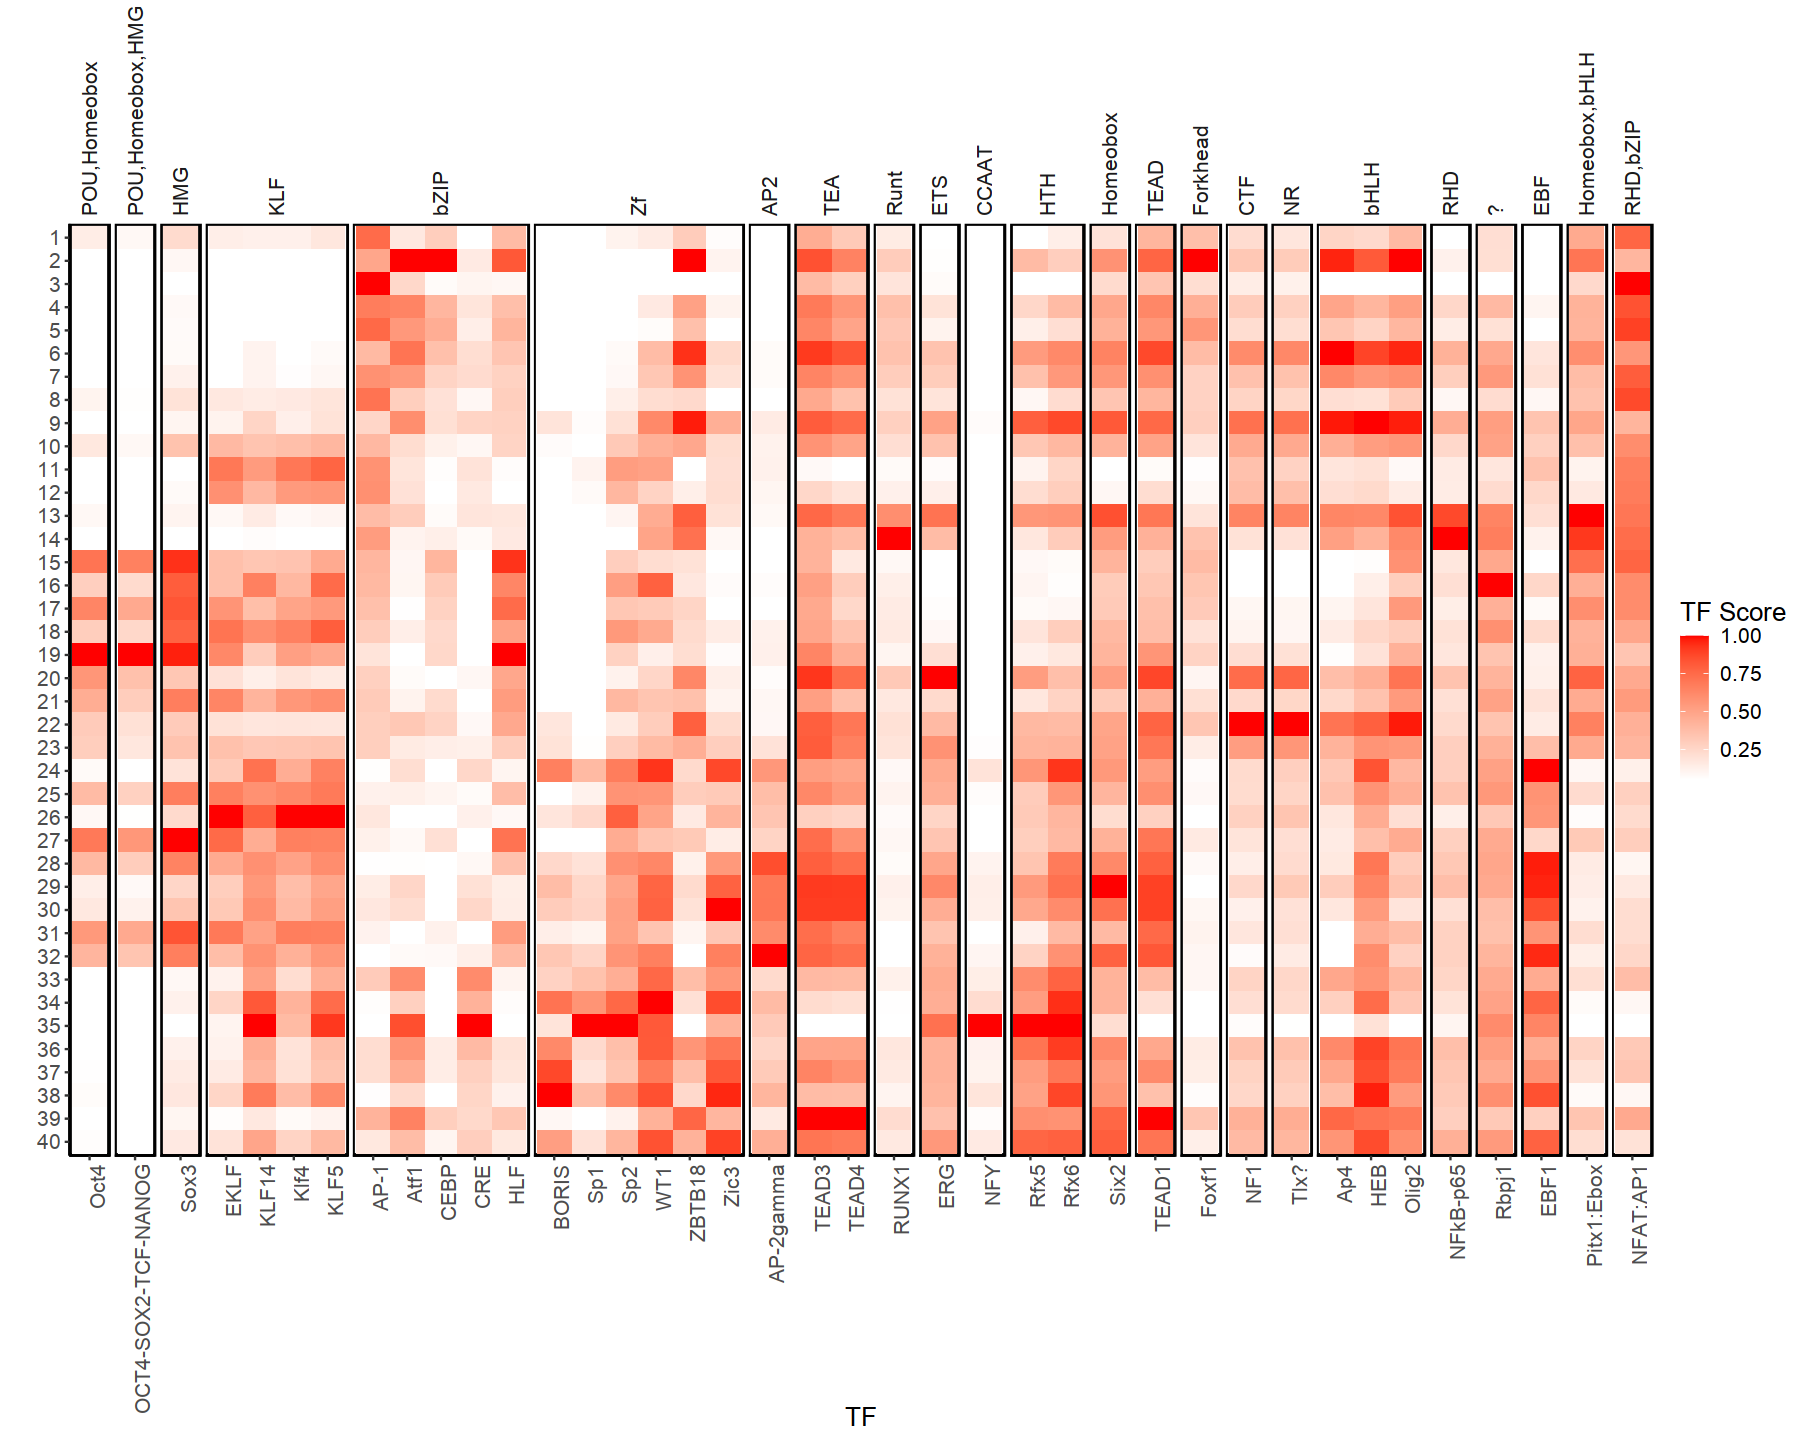

In [1016]:
options(repr.plot.width = 15, repr.plot.height = 12)


pg <- ggplotGrob(p)

# avoid stripping of facet label
# https://stackoverflow.com/questions/49740215/ggplot-facet-grid-label-cut-off
for(i in which(grepl("strip-t", pg$layout$name))){
  pg$grobs[[i]]$layout$clip <- "off"
}

grid::grid.draw(pg)

In [958]:
peak_x_motif_counts[,grepl("Mef", colnames(peak_x_motif_counts))]

idx1  idx2  idx3  idx4  idx5  idx6  idx7  idx8  idx9 idx10 idx11 idx12 idx13 
   38    79    34   226   140   132   232    70    94    79     4    13    43 
idx14 idx15 idx16 idx17 idx18 idx19 idx20 idx21 idx22 idx23 idx24 idx25 idx26 
   33    48    18    80    21    34    11    78    16    22    22    68    10 
idx27 idx28 idx29 idx30 idx31 idx32 idx33 idx34 idx35 idx36 idx37 idx38 idx39 
   52    30    11     7    27    19    97    46    29    58    32    43    26 
idx40 
   28

### OSK Ratios

In [835]:
osk_counts = peak_x_motif_counts[,grepl("Oct4|Sox3|Klf4", colnames(peak_x_motif_counts), ignore.case = F)]
rownames(osk_counts) = sub('idx', '', rownames(osk_counts))
head(osk_counts)

,Klf4(Zf),"Oct4(POU,Homeobox)",Sox3(HMG)
1,260,520,591
2,19,181,493
3,101,185,423
4,217,482,1230
5,104,409,967
6,263,380,668


In [836]:
osk_frac_melted = melt(osk_counts/rowSums(osk_counts))
osk_frac_melted$Var1 = factor(osk_frac_melted$Var1, levels=sort(unique(osk_frac_melted$Var1)))

head(osk_frac_melted, 2)

,Var1,Var2,value
,<fct>,<fct>,<dbl>
1,1,Klf4(Zf),0.18964260
2,2,Klf4(Zf),0.02741703


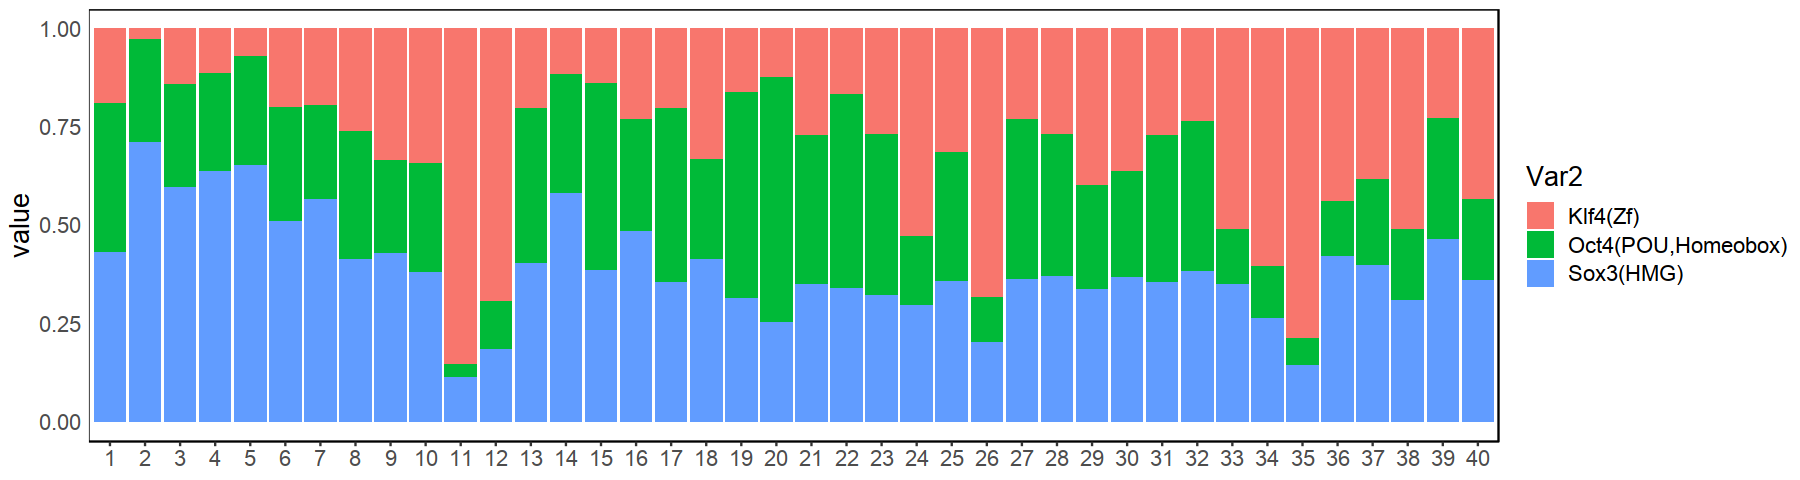

In [837]:
options(repr.plot.width = 15, repr.plot.height = 4)

ggplot(osk_frac_melted, aes(x=Var1, y=value, fill=Var2)) +
geom_bar(position='fill', stat='identity') +
theme_classic() +
theme(plot.title = element_text(hjust = 0.5),
    text = element_text(size=16),
    axis.line=element_blank(),
    axis.ticks.y=element_blank(),
    axis.title.x = element_blank(),
    panel.border = element_rect(colour = "black", fill=NA, size=0.5))